===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1067
Rows that have all features = NaN: 21

=== Rolling Window for Base Date 2025-01-02 ===
Training cutoff: 2024-08-01, Validation cutoff: 2024-12-31

--- Training LSTM for base date 2025-01-02 ---
[LSTM] Completed training for base date 2025-01-02

--- Training GRU for base date 2025-01-02 ---
[GRU] Completed training for base date 2025-01-02

--- Training RNN for base date 2025-01-02 ---
[RNN] Completed training for base date 2025-01-02

--- Training CNN for base date 2025-01-02 ---
[CNN] Completed training for base date 2025-01-02

--- Training Transformer for base date 2025-01-02 ---
[Transformer] Completed training for base date 2025-01-02

--- Training N-BEATS for base date 2025-01-02 ---
[N-BEATS] Completed training for base date 2025-01-02

--- Training N-HITS for base date 2025-01-02 ---
[N-HITS] Completed training for base date 2025-01-02

--- T

/tmp/ipykernel_329597/3394875629.py:442: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(group_conf)


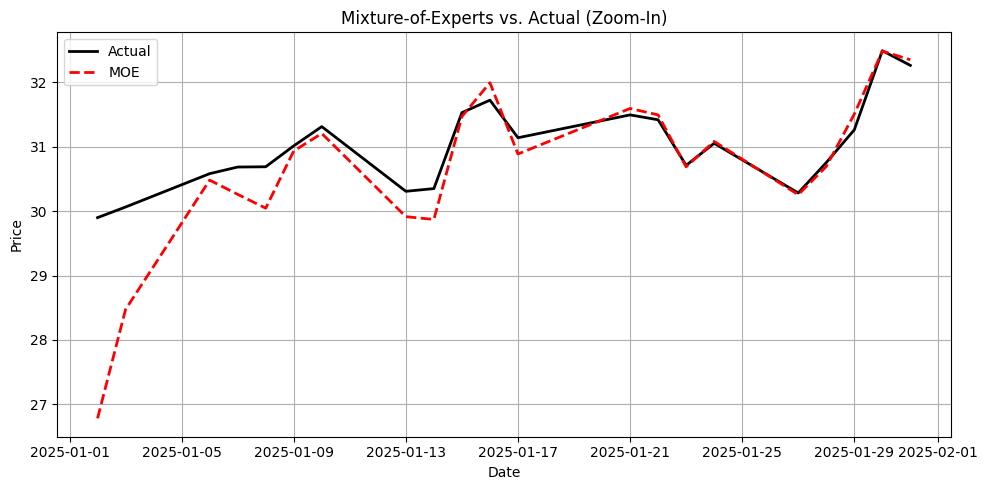


All done with rolling training, validation and prediction.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from datetime import timedelta

# 1) SUPPRESS ALL WARNINGS
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# ============================================
# Global seeds & settings
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Hyperparameters
WINDOW_SIZE = 35
NUM_EPOCHS  = 100
features = ["Price", "Open", "High", "Low"]

# File paths
csv_file_train    = "Silver Futures Historical Data.csv"
csv_file_complete = "Silver Futures Historical Data_Complete.csv"
best_models_dir   = "."

# ============================================
# 2. Load & Clean CSV for Training
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)
print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ============================================
# 3. Fit MinMaxScaler on TRAIN only (for original static training)
# ============================================
df_train_nonan = df[df["Date"] < pd.to_datetime("2024-08-01")].dropna(subset=features)
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

# ============================================
# 5. Validation & Prediction Utilities
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

def inverse_transform_4cols(y_4, scaler_obj):
    return scaler_obj.inverse_transform(y_4)

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    criterion = nn.MSELoss()
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    model.eval()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features].values.astype(float, copy=False)
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    pred_df.sort_values("Date", inplace=True)
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled, scaler)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:,0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:,1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:,2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:,3]
    return pred_df

def forecast_30_days_from_date(model, df_actual, start_date, window=35, horizon=30, device=torch.device("cpu"), scaler=None):
    # Get latest available window before start_date
    def get_latest_window(actual_df, current_date, window=35, scaler=None):
        mask = actual_df["Date"] < current_date
        df_sub = actual_df.loc[mask].copy()
        df_sub.sort_values("Date", inplace=True)
        if len(df_sub) < window:
            return None
        df_window = df_sub.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr = scaler.transform(df_window[features])
        return arr
    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()
    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    current_date = pd.to_datetime(start_date)
    for i in range(horizon):
        X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled = model(X_input).cpu().numpy()[0]
        pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]
        dayx = current_date + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_unscaled[0],
            "Pred_Open_unscaled":  pred_unscaled[1],
            "Pred_High_unscaled":  pred_unscaled[2],
            "Pred_Low_unscaled":   pred_unscaled[3],
        })
        rolling_buffer = np.vstack((rolling_buffer[1:], pred_scaled.reshape(1, -1)))
    return pd.DataFrame(forecast_records)

# ============================================
# 6. Sklearn Wrapper for non-torch models
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1, -1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

# ============================================
# 7. Walk-forward Test for static prediction (for reference)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx = df_work.index[df_work["Date"] == d]
            if len(idx) == 0:
                continue
            idx = idx[0]
            start_idx = idx - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            y_pred_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx, features] = y_pred_scaled
            preds.append((d, *y_pred_scaled))
    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled, scaler)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:, 0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:, 1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:, 2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:, 3]
    return pred_df.sort_values("Date")

# ============================================
# 8. Plotting Functions (unchanged from your previous code)
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    arr_scaled = df_real_plot[features].values
    arr_unscaled = inverse_transform_4cols(arr_scaled, scaler)
    df_real_plot["Real_Price_unscaled"] = arr_unscaled[:, 0]
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"], color="black", label="Actual (Train+Val)")
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, info in results_dict.items():
        val_df = info["val_pred_df"]
        test_df = info["test_pred_df"]
        frames = []
        if val_df is not None:
            frames.append(val_df.rename(columns={"Pred_Price_unscaled": f"Pred_{mname}"}))
        if test_df is not None:
            frames.append(test_df.rename(columns={"Pred_Price_unscaled": f"Pred_{mname}"}))
        if frames:
            comb = pd.concat(frames, ignore_index=True)
            comb = comb[["Date", f"Pred_{mname}"]].drop_duplicates("Date")
            comb.sort_values("Date", inplace=True)
            merged_df = pd.merge(merged_df, comb, on="Date", how="left")
    for mname in results_dict.keys():
        col = f"Pred_{mname}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(mname, "gray"), linestyle="-", label=f"{mname} Pred")
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Predictions (Silver Futures)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_moe_vs_actual(df_moe, start_date, end_date):
    dfp = df_moe[(df_moe["ForecastDate"] >= start_date) & (df_moe["ForecastDate"] <= end_date)].copy()
    if dfp.empty:
        print("No MoE data in specified window.")
        return
    plt.figure(figsize=(10,5))
    plt.plot(dfp["ForecastDate"], dfp["ActualPrice"], color="black", lw=2, label="Actual")
    plt.plot(dfp["ForecastDate"], dfp["MOE_Pred"], color="red", lw=2, linestyle="--", label="MOE")
    plt.title("Mixture-of-Experts vs. Actual (Zoom-In)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def compute_confidences_and_top3(final_rolling_fcst, df_actual):
    df_pred = final_rolling_fcst[["ForecastDate", "Model", "Pred_Price_unscaled"]].copy()
    df_a = df_actual.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"})
    df_merged = pd.merge(df_pred, df_a[["ForecastDate", "ActualPrice"]], on="ForecastDate", how="inner")
    df_merged.dropna(subset=["ActualPrice", "Pred_Price_unscaled"], inplace=True)
    df_merged["AbsError"] = (df_merged["Pred_Price_unscaled"] - df_merged["ActualPrice"]).abs()
    def group_conf(grp):
        err_min = grp["AbsError"].min()
        err_max = grp["AbsError"].max()
        if abs(err_max - err_min) < 1e-9:
            grp["Confidence"] = 1.0
        else:
            grp["Confidence"] = 1.0 - ((grp["AbsError"] - err_min) / (err_max - err_min))
        return grp
    df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(group_conf)
    unq_days = sorted(df_out["ForecastDate"].unique())
    for d in unq_days:
        day_grp = df_out[df_out["ForecastDate"] == d].copy()
        day_grp.sort_values("AbsError", inplace=True)
        top_3 = day_grp.head(3)
        print(f"\n=== {d.date()} ===")
        for _, row in top_3.iterrows():
            print(f"  Model={row['Model']}, Error={row['AbsError']:.3f}, Conf={row['Confidence']:.3f}")
    return df_out[["ForecastDate", "Model", "Pred_Price_unscaled", "AbsError", "Confidence", "ActualPrice"]].copy()

def produce_moe_predictions(df_conf):
    grouped = []
    best_model_records = []
    for fdate, grp in df_conf.groupby("ForecastDate"):
        grp_sorted = grp.sort_values("Confidence", ascending=False).reset_index(drop=True)
        top3 = grp_sorted.head(3).copy()
        sum_conf = top3["Confidence"].sum()
        if abs(sum_conf) < 1e-9:
            top3["NormConf"] = 1.0 / 3.0
        else:
            top3["NormConf"] = top3["Confidence"] / sum_conf
        moe_pred = (top3["NormConf"] * top3["Pred_Price_unscaled"]).sum()
        actual = grp["ActualPrice"].iloc[0]
        moe_abs_err = abs(moe_pred - actual)
        best_model = grp_sorted.loc[0, "Model"]
        best_conf = grp_sorted.loc[0, "Confidence"]
        best_err = grp_sorted.loc[0, "AbsError"]
        best_model_records.append({
            "ForecastDate": fdate,
            "BestModel": best_model,
            "BestModelConf": best_conf,
            "BestModelError": best_err
        })
        grouped.append({
            "ForecastDate": fdate,
            "MOE_Pred": moe_pred,
            "ActualPrice": actual,
            "MOE_AbsError": moe_abs_err
        })
    df_moe = pd.DataFrame(grouped)
    df_best = pd.DataFrame(best_model_records)
    print("\n===== Best Model of the Day (highest confidence) =====")
    for i, row in df_best.sort_values("ForecastDate").iterrows():
        print(f"{row['ForecastDate'].date()}: {row['BestModel']} (Conf={row['BestModelConf']:.3f}, Error={row['BestModelError']:.3f})")
    return df_moe[["ForecastDate", "MOE_Pred", "ActualPrice", "MOE_AbsError"]]

# ============================================
# 9. NEW: Rolling Training, Validation & Prediction
# ============================================
def rolling_train_validate_predict(df, df_complete_all,
                                   initial_train_cutoff, initial_val_cutoff,
                                   window_size, horizon, all_model_types,
                                   best_models_dir, base_start_date, base_end_date):
    """
    For each base prediction date (from base_start_date to base_end_date), this function:
      - Shifts the training and validation cutoffs by the appropriate offset.
      - Prepares a new rolling training set and fits a new scaler.
      - Trains (or loads) each model type and stores the model with a name that includes the base date.
      - Forecasts the next 'horizon' days using the newly trained models.
    """
    rolling_results = []
    base_dates = pd.date_range(start=base_start_date, end=base_end_date, freq="D")
    for base_date in base_dates:
        offset = (base_date - pd.to_datetime(base_start_date)).days
        new_train_cutoff = initial_train_cutoff + timedelta(days=offset)
        new_val_cutoff = initial_val_cutoff + timedelta(days=offset)
        # By design, the base_date equals new_val_cutoff + 2 days.
        print(f"\n=== Rolling Window for Base Date {base_date.date()} ===")
        print(f"Training cutoff: {new_train_cutoff.date()}, Validation cutoff: {new_val_cutoff.date()}")
        
        # Create rolling training and validation sets
        df_roll_train = df[df["Date"] < new_train_cutoff].copy()
        df_roll_val = df[(df["Date"] >= new_train_cutoff) & (df["Date"] <= new_val_cutoff)].copy()
        df_roll_train_nonan = df_roll_train.dropna(subset=features)
        if df_roll_train_nonan.empty:
            print("No valid training rows for this window, skipping.")
            continue
        
        # Fit a new scaler on the rolling training data
        scaler_roll = MinMaxScaler()
        scaler_roll.fit(df_roll_train_nonan[features])
        
        # Scale the rolling training and validation data
        df_roll_train_scaled = df_roll_train.copy()
        df_roll_train_scaled.loc[df_roll_train_nonan.index, features] = scaler_roll.transform(df_roll_train_nonan[features])
        df_roll_val_scaled = df_roll_val.copy()
        df_roll_val_nonan = df_roll_val_scaled.dropna(subset=features)
        if not df_roll_val_nonan.empty:
            df_roll_val_scaled.loc[df_roll_val_nonan.index, features] = scaler_roll.transform(df_roll_val_nonan[features])
        df_roll_scaled = pd.concat([df_roll_train_scaled, df_roll_val_scaled], ignore_index=True)
        
        # Prepare training sequences from rolling training data
        df_roll_train_nonan = df_roll_train_scaled.dropna(subset=features)
        X_train_all, y_train_all, _ = make_sequences(df_roll_train_nonan, window=window_size)
        if len(X_train_all) == 0:
            print("Not enough data for training sequences, skipping.")
            continue
        X_train_tensor = torch.from_numpy(X_train_all).float()
        y_train_tensor = torch.from_numpy(y_train_all).float()
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader_roll = DataLoader(train_dataset, batch_size=32, shuffle=False)
        
        # For each model type, train (or load) a model using the rolling training set
        models_rolling = {}
        for mt in all_model_types:
            print(f"\n--- Training {mt} for base date {base_date.date()} ---")
            if mt in ["SVM", "GPR", "Boost"]:
                best_path = os.path.join(best_models_dir, f"best_{mt}_{base_date.date()}_Mixture of Experts_V1.pkl")
                if os.path.exists(best_path):
                    loaded_model = joblib.load(best_path)
                    print(f"[{mt}] Loaded existing model from {best_path}")
                    models_rolling[mt] = SklearnWrapper(loaded_model)
                else:
                    if mt == "SVM":
                        base_model = SVR(kernel='rbf', C=10, epsilon=0.01)
                    elif mt == "GPR":
                        base_model = GaussianProcessRegressor(alpha=1e-2)
                    elif mt == "Boost":
                        base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
                    else:
                        raise ValueError("Unsupported sklearn model")
                    multi_model = MultiOutputRegressor(base_model)
                    X_train_flat_roll = X_train_all.reshape((X_train_all.shape[0], window_size * 4))
                    multi_model.fit(X_train_flat_roll, y_train_all)
                    joblib.dump(multi_model, best_path)
                    print(f"[{mt}] Trained and saved model to {best_path}")
                    models_rolling[mt] = SklearnWrapper(multi_model)
            else:
                best_path = os.path.join(best_models_dir, f"best_{mt}_{base_date.date()}_Mixture of Experts_V1.pt")
                if os.path.exists(best_path):
                    model_obj = BaseModel(mt, window_size).to(device)
                    model_obj.load_state_dict(torch.load(best_path, map_location=device))
                    print(f"[{mt}] Loaded existing model from {best_path}")
                    models_rolling[mt] = model_obj
                else:
                    model_obj = BaseModel(mt, window_size).to(device)
                    criterion = nn.MSELoss()
                    optimizer = optim.AdamW(model_obj.parameters(), lr=0.005)
                    early_stopper = EarlyStopping(patience=150)
                    best_loss = float("inf")
                    for epoch in range(NUM_EPOCHS):
                        model_obj.train()
                        epoch_losses = []
                        for Xb, yb in train_loader_roll:
                            Xb, yb = Xb.to(device), yb.to(device)
                            optimizer.zero_grad()
                            out = model_obj(Xb)
                            loss = criterion(out, yb)
                            loss.backward()
                            optimizer.step()
                            epoch_losses.append(loss.item())
                        val_loss = half_blind_validation_loss(model_obj, df_roll_scaled, new_train_cutoff, new_val_cutoff, window=window_size)
                        early_stopper(val_loss)
                        if val_loss < best_loss:
                            best_loss = val_loss
                            torch.save(model_obj.state_dict(), best_path)
                        if early_stopper.early_stop:
                            print(f"[{mt}] Early stopping at epoch {epoch+1}")
                            break
                    model_obj.load_state_dict(torch.load(best_path, map_location=device))
                    print(f"[{mt}] Completed training for base date {base_date.date()}")
                    models_rolling[mt] = model_obj
        
        # Now perform forecast using each model
        # First, prepare the complete dataset for prediction: sort, fill NaNs, and scale using scaler_roll
        df_complete_all_sorted = df_complete_all.copy()
        df_complete_all_sorted.sort_values("Date", inplace=True)
        df_complete_all_scaled = df_complete_all_sorted.copy()
        train_mins = df_roll_train_nonan[features].min()
        df_complete_all_scaled[features] = df_complete_all_scaled[features].fillna(train_mins)
        df_complete_all_scaled[features] = scaler_roll.transform(df_complete_all_scaled[features])
        
        for mt, model_obj in models_rolling.items():
            df_fcst = forecast_30_days_from_date(
                model=model_obj,
                df_actual=df_complete_all_scaled,
                start_date=str(base_date.date()),
                window=window_size,
                horizon=horizon,
                device=device,
                scaler=scaler_roll
            )
            if df_fcst.empty:
                continue
            df_fcst["BaseDate"] = base_date
            df_fcst["Model"] = mt
            rolling_results.append(df_fcst)
    if rolling_results:
        df_all_fc = pd.concat(rolling_results, ignore_index=True)
        df_all_fc.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_fc.reset_index(drop=True, inplace=True)
    else:
        df_all_fc = pd.DataFrame()
    return df_all_fc

# ============================================
# 10. MAIN
# ============================================
if __name__ == "__main__":
    # Load complete CSV for prediction (rolling test)
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for c in features:
        df_complete_all[c] = df_complete_all[c].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)
    
    # Define initial cutoffs (for the first rolling window)
    initial_train_cutoff = pd.to_datetime("2024-08-01")
    initial_val_cutoff = pd.to_datetime("2024-12-31")
    
    # Define rolling prediction parameters:
    # Base prediction dates from 2025-01-02 to 2025-01-31, with each forecast horizon = 30 days.
    base_start_date = "2025-01-02"
    base_end_date   = "2025-01-31"
    forecast_horizon = 30
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    
    # Run the rolling training, validation and forecasting procedure
    df_all_fc = rolling_train_validate_predict(df, df_complete_all,
                                               initial_train_cutoff, initial_val_cutoff,
                                               WINDOW_SIZE, forecast_horizon, all_model_types,
                                               best_models_dir, base_start_date, base_end_date)
    
    print("\n===== ROLLING FORECASTS (Rolling Training + MOE) =====")
    print(df_all_fc.head(50))
    print("Total rows in rolling forecast:", len(df_all_fc))
    
    # Compute confidence and MOE forecasts from the rolling predictions
    df_conf = compute_confidences_and_top3(df_all_fc, df_complete_all)
    df_moe = produce_moe_predictions(df_conf)
    
    print("\n===== MOE DataFrame (head) =====")
    print(df_moe.head(20))
    plot_moe_vs_actual(df_moe, pd.to_datetime("2025-01-01"), pd.to_datetime("2025-01-31"))
    
    print("\nAll done with rolling training, validation and prediction.")


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import random
import joblib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
from datetime import timedelta

# 1) SUPPRESS ALL WARNINGS
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

# ============================================
# Global seeds & settings
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Hyperparameters
WINDOW_SIZE = 35
NUM_EPOCHS  = 100
features = ["Price", "Open", "High", "Low"]

# File paths
csv_file_train    = "Silver Futures Historical Data.csv"
csv_file_complete = "Silver Futures Historical Data_Complete.csv"
best_models_dir   = "."

# ============================================
# 2. Load & Clean CSV for Training
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)
print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# ============================================
# 3. Fit MinMaxScaler on TRAIN only (for original static training)
# ============================================
df_train_nonan = df[df["Date"] < pd.to_datetime("2024-08-01")].dropna(subset=features)
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

# ============================================
# 5. Validation & Prediction Utilities
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

def inverse_transform_4cols(y_4, scaler_obj):
    return scaler_obj.inverse_transform(y_4)

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    criterion = nn.MSELoss()
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    model.eval()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features].values.astype(float, copy=False)
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())
    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))
    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    pred_df.sort_values("Date", inplace=True)
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled, scaler)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:,0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:,1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:,2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:,3]
    return pred_df

def forecast_30_days_from_date(model, df_actual, start_date, window=35, horizon=30, device=torch.device("cpu"), scaler=None):
    # Get latest available window before start_date
    def get_latest_window(actual_df, current_date, window=35, scaler=None):
        mask = actual_df["Date"] < current_date
        df_sub = actual_df.loc[mask].copy()
        df_sub.sort_values("Date", inplace=True)
        if len(df_sub) < window:
            return None
        df_window = df_sub.iloc[-window:].copy()
        df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
        arr = scaler.transform(df_window[features])
        return arr
    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()
    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    current_date = pd.to_datetime(start_date)
    for i in range(horizon):
        X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled = model(X_input).cpu().numpy()[0]
        pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(1, -1))[0]
        dayx = current_date + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_unscaled[0],
            "Pred_Open_unscaled":  pred_unscaled[1],
            "Pred_High_unscaled":  pred_unscaled[2],
            "Pred_Low_unscaled":   pred_unscaled[3],
        })
        rolling_buffer = np.vstack((rolling_buffer[1:], pred_scaled.reshape(1, -1)))
    return pd.DataFrame(forecast_records)

# ============================================
# 6. Sklearn Wrapper for non-torch models
# ============================================
class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1, -1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

# ============================================
# 7. Walk-forward Test for static prediction (for reference)
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds = []
    test_dates = np.sort(df_work[df_work["Date"] >= test_start]["Date"].unique())
    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx = df_work.index[df_work["Date"] == d]
            if len(idx) == 0:
                continue
            idx = idx[0]
            start_idx = idx - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            y_pred_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx, features] = y_pred_scaled
            preds.append((d, *y_pred_scaled))
    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled, scaler)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:, 0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:, 1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:, 2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:, 3]
    return pred_df.sort_values("Date")

def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    arr_scaled = df_real_plot[features].values
    arr_unscaled = inverse_transform_4cols(arr_scaled, scaler)
    df_real_plot["Real_Price_unscaled"] = arr_unscaled[:, 0]
    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"], color="black", label="Actual (Train+Val)")
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    for mname, info in results_dict.items():
        val_df = info["val_pred_df"]
        test_df = info["test_pred_df"]
        frames = []
        if val_df is not None:
            frames.append(val_df.rename(columns={"Pred_Price_unscaled": f"Pred_{mname}"}))
        if test_df is not None:
            frames.append(test_df.rename(columns={"Pred_Price_unscaled": f"Pred_{mname}"}))
        if frames:
            comb = pd.concat(frames, ignore_index=True)
            comb = comb[["Date", f"Pred_{mname}"]].drop_duplicates("Date")
            comb.sort_values("Date", inplace=True)
            merged_df = pd.merge(merged_df, comb, on="Date", how="left")
    for mname in results_dict.keys():
        col = f"Pred_{mname}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(mname, "gray"), linestyle="-", label=f"{mname} Pred")
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")
    plt.title("Joint Diagram: Actual Price vs. Predictions (Silver Futures)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def plot_moe_vs_actual(df_moe, start_date, end_date):
    dfp = df_moe[(df_moe["ForecastDate"] >= start_date) & (df_moe["ForecastDate"] <= end_date)].copy()
    if dfp.empty:
        print("No MoE data in specified window.")
        return
    plt.figure(figsize=(10,5))
    plt.plot(dfp["ForecastDate"], dfp["ActualPrice"], color="black", lw=2, label="Actual")
    plt.plot(dfp["ForecastDate"], dfp["MOE_Pred"], color="red", lw=2, linestyle="--", label="MOE")
    plt.title("Mixture-of-Experts vs. Actual (Zoom-In)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def compute_confidences_and_top3(final_rolling_fcst, df_actual):
    df_pred = final_rolling_fcst[["ForecastDate", "Model", "Pred_Price_unscaled"]].copy()
    df_a = df_actual.rename(columns={"Date": "ForecastDate", "Price": "ActualPrice"})
    df_merged = pd.merge(df_pred, df_a[["ForecastDate", "ActualPrice"]], on="ForecastDate", how="inner")
    df_merged.dropna(subset=["ActualPrice", "Pred_Price_unscaled"], inplace=True)
    df_merged["AbsError"] = (df_merged["Pred_Price_unscaled"] - df_merged["ActualPrice"]).abs()
    def group_conf(grp):
        err_min = grp["AbsError"].min()
        err_max = grp["AbsError"].max()
        if abs(err_max - err_min) < 1e-9:
            grp["Confidence"] = 1.0
        else:
            grp["Confidence"] = 1.0 - ((grp["AbsError"] - err_min) / (err_max - err_min))
        return grp
    df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(group_conf)
    unq_days = sorted(df_out["ForecastDate"].unique())
    for d in unq_days:
        day_grp = df_out[df_out["ForecastDate"] == d].copy()
        day_grp.sort_values("AbsError", inplace=True)
        top_3 = day_grp.head(3)
        print(f"\n=== {d.date()} ===")
        for _, row in top_3.iterrows():
            print(f"  Model={row['Model']}, Error={row['AbsError']:.3f}, Conf={row['Confidence']:.3f}")
    return df_out[["ForecastDate", "Model", "Pred_Price_unscaled", "AbsError", "Confidence", "ActualPrice"]].copy()

def produce_moe_predictions(df_conf):
    grouped = []
    best_model_records = []
    for fdate, grp in df_conf.groupby("ForecastDate"):
        grp_sorted = grp.sort_values("Confidence", ascending=False).reset_index(drop=True)
        top3 = grp_sorted.head(3).copy()
        sum_conf = top3["Confidence"].sum()
        if abs(sum_conf) < 1e-9:
            top3["NormConf"] = 1.0 / 3.0
        else:
            top3["NormConf"] = top3["Confidence"] / sum_conf
        moe_pred = (top3["NormConf"] * top3["Pred_Price_unscaled"]).sum()
        actual = grp["ActualPrice"].iloc[0]
        moe_abs_err = abs(moe_pred - actual)
        best_model = grp_sorted.loc[0, "Model"]
        best_conf = grp_sorted.loc[0, "Confidence"]
        best_err = grp_sorted.loc[0, "AbsError"]
        best_model_records.append({
            "ForecastDate": fdate,
            "BestModel": best_model,
            "BestModelConf": best_conf,
            "BestModelError": best_err
        })
        grouped.append({
            "ForecastDate": fdate,
            "MOE_Pred": moe_pred,
            "ActualPrice": actual,
            "MOE_AbsError": moe_abs_err
        })
    df_moe = pd.DataFrame(grouped)
    df_best = pd.DataFrame(best_model_records)
    print("\n===== Best Model of the Day (highest confidence) =====")
    for i, row in df_best.sort_values("ForecastDate").iterrows():
        print(f"{row['ForecastDate'].date()}: {row['BestModel']} (Conf={row['BestModelConf']:.3f}, Error={row['BestModelError']:.3f})")
    return df_moe[["ForecastDate", "MOE_Pred", "ActualPrice", "MOE_AbsError"]]

# ============================================
# 9. NEW: Rolling Training, Validation & Prediction
# ============================================
def rolling_train_validate_predict(df, df_complete_all,
                                   initial_train_cutoff, initial_val_cutoff,
                                   window_size, horizon, all_model_types,
                                   best_models_dir, base_start_date, base_end_date):
    """
    For each base prediction date (from base_start_date to base_end_date), this function:
      - Shifts the training and validation cutoffs by the appropriate offset.
      - Prepares a new rolling training set and fits a new scaler.
      - Trains (or loads) each model type and stores the model with a name that includes the base date.
      - Forecasts the next 'horizon' days using the newly trained models.
    """
    rolling_results = []
    base_dates = pd.date_range(start=base_start_date, end=base_end_date, freq="D")
    for base_date in base_dates:
        offset = (base_date - pd.to_datetime(base_start_date)).days
        new_train_cutoff = initial_train_cutoff + timedelta(days=offset)
        new_val_cutoff = initial_val_cutoff + timedelta(days=offset)
        # By design, the base_date equals new_val_cutoff + 2 days.
        print(f"\n=== Rolling Window for Base Date {base_date.date()} ===")
        print(f"Training cutoff: {new_train_cutoff.date()}, Validation cutoff: {new_val_cutoff.date()}")
        
        # Create rolling training and validation sets
        df_roll_train = df[df["Date"] < new_train_cutoff].copy()
        df_roll_val = df[(df["Date"] >= new_train_cutoff) & (df["Date"] <= new_val_cutoff)].copy()
        df_roll_train_nonan = df_roll_train.dropna(subset=features)
        if df_roll_train_nonan.empty:
            print("No valid training rows for this window, skipping.")
            continue
        
        # Fit a new scaler on the rolling training data
        scaler_roll = MinMaxScaler()
        scaler_roll.fit(df_roll_train_nonan[features])
        
        # Scale the rolling training and validation data
        df_roll_train_scaled = df_roll_train.copy()
        df_roll_train_scaled.loc[df_roll_train_nonan.index, features] = scaler_roll.transform(df_roll_train_nonan[features])
        df_roll_val_scaled = df_roll_val.copy()
        df_roll_val_nonan = df_roll_val_scaled.dropna(subset=features)
        if not df_roll_val_nonan.empty:
            df_roll_val_scaled.loc[df_roll_val_nonan.index, features] = scaler_roll.transform(df_roll_val_nonan[features])
        df_roll_scaled = pd.concat([df_roll_train_scaled, df_roll_val_scaled], ignore_index=True)
        
        # Prepare training sequences from rolling training data
        df_roll_train_nonan = df_roll_train_scaled.dropna(subset=features)
        X_train_all, y_train_all, _ = make_sequences(df_roll_train_nonan, window=window_size)
        if len(X_train_all) == 0:
            print("Not enough data for training sequences, skipping.")
            continue
        X_train_tensor = torch.from_numpy(X_train_all).float()
        y_train_tensor = torch.from_numpy(y_train_all).float()
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader_roll = DataLoader(train_dataset, batch_size=32, shuffle=False)
        
        # For each model type, train (or load) a model using the rolling training set
        models_rolling = {}
        for mt in all_model_types:
            print(f"\n--- Training {mt} for base date {base_date.date()} ---")
            if mt in ["SVM", "GPR", "Boost"]:
                best_path = os.path.join(best_models_dir, f"best_{mt}_{base_date.date()}_Mixture of Experts_V1.pkl")
                if os.path.exists(best_path):
                    loaded_model = joblib.load(best_path)
                    print(f"[{mt}] Loaded existing model from {best_path}")
                    models_rolling[mt] = SklearnWrapper(loaded_model)
                else:
                    if mt == "SVM":
                        base_model = SVR(kernel='rbf', C=10, epsilon=0.01)
                    elif mt == "GPR":
                        base_model = GaussianProcessRegressor(alpha=1e-2)
                    elif mt == "Boost":
                        base_model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
                    else:
                        raise ValueError("Unsupported sklearn model")
                    multi_model = MultiOutputRegressor(base_model)
                    X_train_flat_roll = X_train_all.reshape((X_train_all.shape[0], window_size * 4))
                    multi_model.fit(X_train_flat_roll, y_train_all)
                    joblib.dump(multi_model, best_path)
                    print(f"[{mt}] Trained and saved model to {best_path}")
                    models_rolling[mt] = SklearnWrapper(multi_model)
            else:
                best_path = os.path.join(best_models_dir, f"best_{mt}_{base_date.date()}_Mixture of Experts_V1.pt")
                if os.path.exists(best_path):
                    model_obj = BaseModel(mt, window_size).to(device)
                    model_obj.load_state_dict(torch.load(best_path, map_location=device))
                    print(f"[{mt}] Loaded existing model from {best_path}")
                    models_rolling[mt] = model_obj
                else:
                    model_obj = BaseModel(mt, window_size).to(device)
                    criterion = nn.MSELoss()
                    optimizer = optim.AdamW(model_obj.parameters(), lr=0.005)
                    early_stopper = EarlyStopping(patience=150)
                    best_loss = float("inf")
                    for epoch in range(NUM_EPOCHS):
                        model_obj.train()
                        epoch_losses = []
                        for Xb, yb in train_loader_roll:
                            Xb, yb = Xb.to(device), yb.to(device)
                            optimizer.zero_grad()
                            out = model_obj(Xb)
                            loss = criterion(out, yb)
                            loss.backward()
                            optimizer.step()
                            epoch_losses.append(loss.item())
                        val_loss = half_blind_validation_loss(model_obj, df_roll_scaled, new_train_cutoff, new_val_cutoff, window=window_size)
                        early_stopper(val_loss)
                        if val_loss < best_loss:
                            best_loss = val_loss
                            torch.save(model_obj.state_dict(), best_path)
                        if early_stopper.early_stop:
                            print(f"[{mt}] Early stopping at epoch {epoch+1}")
                            break
                    model_obj.load_state_dict(torch.load(best_path, map_location=device))
                    print(f"[{mt}] Completed training for base date {base_date.date()}")
                    models_rolling[mt] = model_obj
        
        # Now perform forecast using each model
        # Prepare complete dataset for prediction: sort, fill NaNs, and scale using scaler_roll
        df_complete_all_sorted = df_complete_all.copy()
        df_complete_all_sorted.sort_values("Date", inplace=True)
        df_complete_all_scaled = df_complete_all_sorted.copy()
        train_mins = df_roll_train_nonan[features].min()
        df_complete_all_scaled[features] = df_complete_all_scaled[features].fillna(train_mins)
        df_complete_all_scaled[features] = scaler_roll.transform(df_complete_all_scaled[features])
        
        for mt, model_obj in models_rolling.items():
            df_fcst = forecast_30_days_from_date(
                model=model_obj,
                df_actual=df_complete_all_scaled,
                start_date=str(base_date.date()),
                window=window_size,
                horizon=horizon,
                device=device,
                scaler=scaler_roll
            )
            if df_fcst.empty:
                continue
            df_fcst["BaseDate"] = base_date
            df_fcst["Model"] = mt
            rolling_results.append(df_fcst)
    if rolling_results:
        df_all_fc = pd.concat(rolling_results, ignore_index=True)
        df_all_fc.sort_values(["Model", "BaseDate", "ForecastDate"], inplace=True)
        df_all_fc.reset_index(drop=True, inplace=True)
    else:
        df_all_fc = pd.DataFrame()
    return df_all_fc

# ========================================================
# NEW PLOTTING FUNCTIONS FOR DAILY & CONCATENATED DIAGRAMS
# ========================================================

def plot_daily_diagrams_by_model(day_i, horizon_days, daily_fcst_dict, df_actual):
    """
    For a given base (forecast) day, this function loops through each model's daily forecast (in daily_fcst_dict)
    and produces:
      - A Joint Diagram: Actual prices vs. that model's forecast for [day_i, day_i+horizon_days]
      - A Zoom-In Diagram: A closer view of the same.
    """
    for m, df_fc in daily_fcst_dict.items():
        day_end = day_i + pd.Timedelta(days=horizon_days)
        # Filter forecast for this model for the day
        df_model_fc = df_fc[(df_fc["ForecastDate"] >= day_i) & (df_fc["ForecastDate"] <= day_end)]
        # Filter actual data for the same range (assuming df_actual has a "Date" column and "Price")
        df_actual_range = df_actual[(df_actual["Date"] >= day_i) & (df_actual["Date"] <= day_end)]
        # Joint Diagram
        plt.figure(figsize=(12,5))
        plt.plot(df_actual_range["Date"], df_actual_range["Price"], color="black", label="Actual Price")
        plt.plot(df_model_fc["ForecastDate"], df_model_fc["Pred_Price_unscaled"], linestyle="--", label=f"{m} Forecast")
        plt.title(f"Daily Joint Diagram for {m} on {day_i.date()}")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        # Zoom-In Diagram
        plt.figure(figsize=(12,5))
        plt.plot(df_actual_range["Date"], df_actual_range["Price"], color="black", label="Actual Price")
        plt.plot(df_model_fc["ForecastDate"], df_model_fc["Pred_Price_unscaled"], linestyle="--", label=f"{m} Forecast")
        plt.title(f"Daily Zoom-In Diagram for {m} on {day_i.date()}")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

def plot_concatenated_joint_diagrams_by_model(df_all_fc):
    """
    For each model in df_all_fc (the final rolling forecast DataFrame),
    this function produces a single figure that concatenates all forecast curves.
    """
    models = df_all_fc["Model"].unique()
    for m in models:
        df_model = df_all_fc[df_all_fc["Model"] == m].copy()
        plt.figure(figsize=(12,6))
        plt.plot(df_model["ForecastDate"], df_model["Pred_Price_unscaled"], linestyle="--", marker="o", label=f"{m} Forecast")
        plt.title(f"Concatenated Joint Diagram for {m}")
        plt.xlabel("Forecast Date")
        plt.ylabel("Predicted Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 10. MAIN
# ============================================
if __name__ == "__main__":
    # Load complete CSV for prediction (rolling test)
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"] = pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)
    for c in features:
        df_complete_all[c] = df_complete_all[c].astype(str).str.replace(",", "", regex=True).astype(float)
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)
    
    # Define initial cutoffs (for the first rolling window)
    initial_train_cutoff = pd.to_datetime("2024-08-01")
    initial_val_cutoff = pd.to_datetime("2024-12-31")
    
    # Define rolling prediction parameters:
    # Base prediction dates from 2025-01-02 to 2025-01-31, with each forecast horizon = 30 days.
    base_start_date = "2025-01-02"
    base_end_date   = "2025-01-31"
    forecast_horizon = 30
    all_model_types = ["LSTM", "GRU", "RNN", "CNN", "Transformer", "N-BEATS", "N-HITS", "SVM", "Boost"]
    
    # Run the rolling training, validation and forecasting procedure
    df_all_fc = rolling_train_validate_predict(df, df_complete_all,
                                               initial_train_cutoff, initial_val_cutoff,
                                               WINDOW_SIZE, forecast_horizon, all_model_types,
                                               best_models_dir, base_start_date, base_end_date)
    
    print("\n===== ROLLING FORECASTS (Rolling Training + MOE) =====")
    print(df_all_fc.head(50))
    print("Total rows in rolling forecast:", len(df_all_fc))
    
    # Compute confidence and MOE forecasts from the rolling predictions
    df_conf = compute_confidences_and_top3(df_all_fc, df_complete_all)
    df_moe = produce_moe_predictions(df_conf)
    
    print("\n===== MOE DataFrame (head) =====")
    print(df_moe.head(20))
    plot_moe_vs_actual(df_moe, pd.to_datetime("2025-01-01"), pd.to_datetime("2025-01-31"))
    
    # ------------------------------------------
    # NEW: For each rolling (base) day, produce daily diagrams per model
    # ------------------------------------------
    unique_base_dates = df_all_fc["BaseDate"].unique()
    for bd in unique_base_dates:
        df_day = df_all_fc[df_all_fc["BaseDate"] == bd]
        # Create a dictionary keyed by model name for this base day
        daily_fcst_dict = {}
        for m in df_day["Model"].unique():
            daily_fcst_dict[m] = df_day[df_day["Model"] == m]
        # Plot daily joint & zoom-in diagrams for each model on this base date
        plot_daily_diagrams_by_model(pd.to_datetime(bd), forecast_horizon, daily_fcst_dict, df_complete_all)
    
    # ------------------------------------------
    # NEW: Plot concatenated joint diagram for each model across all base dates
    # ------------------------------------------
    plot_concatenated_joint_diagrams_by_model(df_all_fc)
    
    print("\nAll done with rolling training, validation, prediction and plotting.")
